In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
import joblib


In [4]:
# Load the data
train = pd.read_csv("data/Training.csv")
test = pd.read_csv("data/Test.csv")


In [5]:
# -------------------------------
# Data Preprocessing
# -------------------------------
def preprocess_data(data, cutoff=1):
    """
    Preprocess the data by:
    - Handling missing values in 'reviewText' and 'summary'
    - Creating a combined 'text' column (summary + reviewText)
    - Converting 'verified' to integer (0 or 1)
    - Converting 'vote' to numeric and binning into 'vote_bins'
    - Creating a binary label: 1 if 'overall' > cutoff, 0 otherwise
    """
    data['reviewText'] = data['reviewText'].fillna("")
    data['summary'] = data['summary'].fillna("")
    data['text'] = data['summary'] + " " + data['reviewText']
    data['verified'] = data['verified'].astype(int)
    data['vote'] = pd.to_numeric(data['vote'], errors='coerce').fillna(0)
    data['vote_bins'] = pd.cut(data['vote'], bins=[-1, 1, 5, 20, 1000], labels=[0, 1, 2, 3])
    data['label'] = (data['overall'] > cutoff).astype(int)
    return data



In [4]:
# Preprocess the training data with cutoff=1
train_preprocessed = preprocess_data(train.copy(), cutoff=1)


In [5]:
# -------------------------------
# Feature Engineering
# -------------------------------
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text = vectorizer.fit_transform(train_preprocessed['text'])

# Process numerical features ('verified' and 'vote_bins')
numerical_features = train_preprocessed[['verified', 'vote_bins']]
scaler = StandardScaler()
X_num = scaler.fit_transform(numerical_features)

# Combine TF-IDF features and numerical features
X_final = np.hstack((X_text.toarray(), X_num))
y_final = train_preprocessed['label']

# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)


In [6]:
# -------------------------------
# Hyperparameter Tuning using GridSearchCV
# -------------------------------
param_grid = {
    'C': [0.1, 1, 10], 
    'solver': ['liblinear'],
    'max_iter': [100],
    'class_weight': ['balanced']
}

logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', verbose=2)
grid_search.fit(X_train, y_train)

# Print best parameters
print(f"✅ Best parameters for Logistic Regression: {grid_search.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   3.2s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.2s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.3s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   1.9s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   1.8s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=10, class_weight=balanced, max_iter=100

In [7]:
# -------------------------------
# Train Best Model
# -------------------------------
best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_val)

# -------------------------------
# Evaluation
# -------------------------------
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("ROC AUC:", roc_auc_score(y_val, y_pred))
print("Macro F1 Score:", f1_score(y_val, y_pred, average='macro'))
print("Accuracy:", accuracy_score(y_val, y_pred))



Confusion Matrix:
[[ 933  258]
 [ 705 3942]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.78      0.66      1191
           1       0.94      0.85      0.89      4647

    accuracy                           0.84      5838
   macro avg       0.75      0.82      0.78      5838
weighted avg       0.86      0.84      0.84      5838

ROC AUC: 0.8158322668561663
Macro F1 Score: 0.7753732864853086
Accuracy: 0.8350462487153134


In [22]:
# -------------------------------
# Save the Model
# -------------------------------
cutoff_value = 1  
joblib.dump(best_nb_model, f"models/best_model_cutoff{cutoff_value}_lg.pkl", compress=3)
print(f"\n✅ Logistic model saved as models/best_model_cutoff{cutoff_value}_lg.pkl")


✅ Logistic model saved as models/best_model_cutoff1_lg.pkl


## ComplementNB Model

In [10]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
import joblib

In [12]:
# -------------------------------
# Data Preprocessing (Reusing train_preprocessed)
# -------------------------------

# Transform text features using the same vectorizer
X_text_nb = vectorizer.transform(train_preprocessed['text'])

# Process numerical features using MinMaxScaler for non-negative values
scaler_nb = MinMaxScaler()
X_num_nb = scaler_nb.fit_transform(train_preprocessed[['verified', 'vote_bins']])


X_final_nb = np.hstack((X_text_nb.toarray(), X_num_nb))
y_final_nb = train_preprocessed['label']

print("TF-IDF feature matrix shape (for NB):", X_text_nb.shape)
print("Combined feature matrix shape (for NB):", X_final_nb.shape)


TF-IDF feature matrix shape (for NB): (29189, 10000)
Combined feature matrix shape (for NB): (29189, 10002)


In [14]:
# -------------------------------
# Train-Test Split
# -------------------------------
X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(
    X_final_nb, y_final_nb, test_size=0.2, random_state=42, stratify=y_final_nb
)

# -------------------------------
# Hyperparameter Tuning using GridSearchCV for ComplementNB
# -------------------------------
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],
    'norm': [True, False] 
}

nb_model = ComplementNB()
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, scoring='f1_macro', verbose=2)
grid_search_nb.fit(X_train_nb, y_train_nb)

# Print best parameters
print(f"✅ Best parameters for ComplementNB: {grid_search_nb.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_nb.best_score_:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...............................alpha=0.1, norm=True; total time=   2.1s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.8s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.5s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.5s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.6s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.6s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.4s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.5s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.4s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.5s
[CV] END ...............................alpha=0.5, norm=True; total time=   1.3s
[CV] END ...............................alpha=0.5

In [15]:
# -------------------------------
# Train Best Model
# -------------------------------
best_nb_model = grid_search_nb.best_estimator_
y_pred_nb = best_nb_model.predict(X_val_nb)

# -------------------------------
# Evaluation
# -------------------------------
print("\nConfusion Matrix (ComplementNB):")
print(confusion_matrix(y_val_nb, y_pred_nb))

print("\nClassification Report (ComplementNB):")
print(classification_report(y_val_nb, y_pred_nb))

print("ROC AUC (ComplementNB):", roc_auc_score(y_val_nb, y_pred_nb))
print("Macro F1 Score (ComplementNB):", f1_score(y_val_nb, y_pred_nb, average='macro'))
print("Accuracy (ComplementNB):", accuracy_score(y_val_nb, y_pred_nb))



Confusion Matrix (ComplementNB):
[[ 825  366]
 [ 527 4120]]

Classification Report (ComplementNB):
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1191
           1       0.92      0.89      0.90      4647

    accuracy                           0.85      5838
   macro avg       0.76      0.79      0.78      5838
weighted avg       0.86      0.85      0.85      5838

ROC AUC (ComplementNB): 0.7896443576446763
Macro F1 Score (ComplementNB): 0.7755313308348136
Accuracy (ComplementNB): 0.8470366563891744


In [16]:
# -------------------------------
# Save the Model
# -------------------------------
cutoff_value = 1  
joblib.dump(best_nb_model, f"models/best_model_cutoff{cutoff_value}_nb.pkl", compress=3)
print(f"\n✅ ComplementNB model saved as models/best_model_cutoff{cutoff_value}_nb.pkl")


✅ ComplementNB model saved as models/best_model_cutoff1_nb.pkl


## LinearSVC

In [20]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
import joblib

# -------------------------------
# Hyperparameter Tuning using GridSearchCV for LinearSVC
# -------------------------------
param_grid_svc = {
    'estimator__C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'estimator__max_iter': [1000],  # Iterations
    'cv': [5]
}

# Instantiate base LinearSVC model
linear_svc = LinearSVC(dual=False)


calibrated_svc = CalibratedClassifierCV(estimator=linear_svc)

# GridSearchCV to find the best hyperparameters
grid_search_svc = GridSearchCV(calibrated_svc, param_grid_svc, cv=5, scoring='f1_macro', verbose=2)
grid_search_svc.fit(X_train, y_train)

# Print best parameters
print(f"✅ Best parameters for Calibrated SVM: {grid_search_svc.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_svc.best_score_:.4f}")


# -------------------------------
# Train Best Model
# -------------------------------
best_svc_model = grid_search_svc.best_estimator_
y_pred_svc = best_svc_model.predict(X_val)

# -------------------------------
# Evaluation
# -------------------------------
print("\nConfusion Matrix (SVM):")
print(confusion_matrix(y_val, y_pred_svc))

print("\nClassification Report (SVM):")
print(classification_report(y_val, y_pred_svc))

print("ROC AUC (SVM):", roc_auc_score(y_val, best_svc_model.predict_proba(X_val)[:, 1]))
print("Macro F1 Score (SVM):", f1_score(y_val, y_pred_svc, average='macro'))
print("Accuracy (SVM):", accuracy_score(y_val, y_pred_svc))

# -------------------------------
# Save the Model
# -------------------------------
joblib.dump(best_svc_model, "models/best_model_cutoff1_svm.pkl", compress=3)
print("\n✅ SVM model saved as models/best_model_cutoff1_svm.pkl")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..cv=5, estimator__C=0.01, estimator__max_iter=1000; total time=   7.9s
[CV] END ..cv=5, estimator__C=0.01, estimator__max_iter=1000; total time=   7.8s
[CV] END ..cv=5, estimator__C=0.01, estimator__max_iter=1000; total time=   7.5s
[CV] END ..cv=5, estimator__C=0.01, estimator__max_iter=1000; total time=  10.0s
[CV] END ..cv=5, estimator__C=0.01, estimator__max_iter=1000; total time=   8.6s
[CV] END ...cv=5, estimator__C=0.1, estimator__max_iter=1000; total time=   8.8s
[CV] END ...cv=5, estimator__C=0.1, estimator__max_iter=1000; total time=   8.0s
[CV] END ...cv=5, estimator__C=0.1, estimator__max_iter=1000; total time=   8.7s
[CV] END ...cv=5, estimator__C=0.1, estimator__max_iter=1000; total time=  11.3s
[CV] END ...cv=5, estimator__C=0.1, estimator__max_iter=1000; total time=  13.1s
[CV] END .....cv=5, estimator__C=1, estimator__max_iter=1000; total time=  11.5s
[CV] END .....cv=5, estimator__C=1, estimator__ma

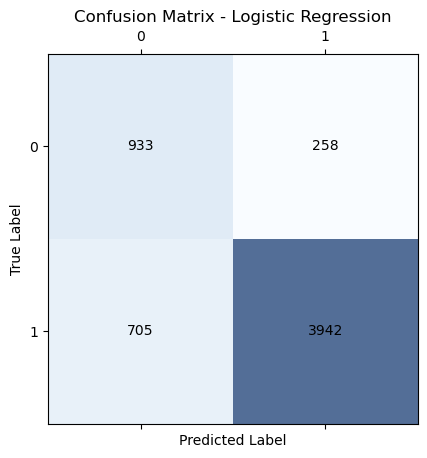

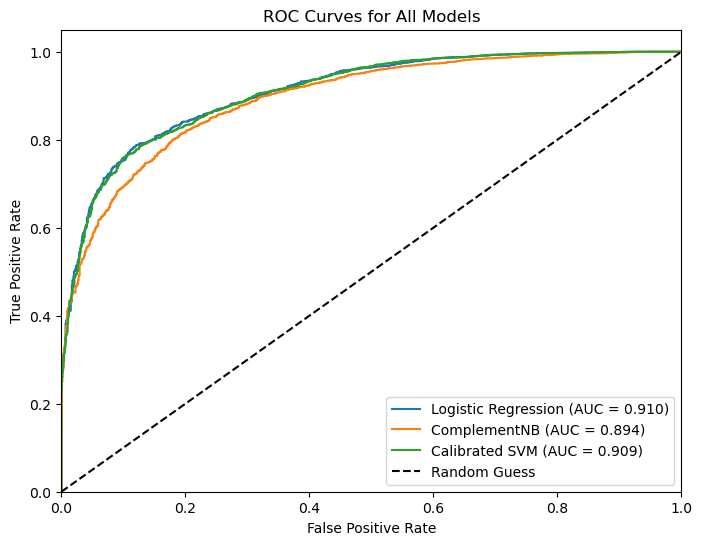

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# -------------------------------
# Compute Confusion Matrices and ROC Curves
# -------------------------------

# Logistic Regression
y_pred_log = best_logreg.predict(X_val)
y_prob_log = best_logreg.predict_proba(X_val)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_val, y_prob_log)

# ComplementNB
y_pred_nb = best_nb_model.predict(X_val_nb)
y_prob_nb = best_nb_model.predict_proba(X_val_nb)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_val_nb, y_prob_nb)

# Calibrated SVM
y_pred_svm = best_svc_model.predict(X_val)
y_prob_svm = best_svc_model.predict_proba(X_val)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_prob_svm)

# -------------------------------
# Plot Confusion Matrices
# -------------------------------

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrices for logistic 
plot_confusion_matrix(y_val, y_pred_log, "Confusion Matrix - Logistic Regression")
# ------------------------------
# Plot ROC Curves
# -------------------------------
plt.figure(figsize=(8, 6))

plt.plot(fpr_log, tpr_log, label="Logistic Regression (AUC = {:.3f})".format(auc(fpr_log, tpr_log)))
plt.plot(fpr_nb, tpr_nb, label="ComplementNB (AUC = {:.3f})".format(auc(fpr_nb, tpr_nb)))
plt.plot(fpr_svm, tpr_svm, label="Calibrated SVM (AUC = {:.3f})".format(auc(fpr_svm, tpr_svm)))

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.show()


In [73]:
# Generate Kaggle Submission for Cutoff=1

# Preprocess the test data similarly as in training:
test['reviewText'] = test['reviewText'].fillna("")
test['summary'] = test['summary'].fillna("")
test['text'] = test['summary'] + " " + test['reviewText']
test['verified'] = test['verified'].astype(int)
test['vote'] = pd.to_numeric(test['vote'], errors='coerce').fillna(0)
test['vote_bins'] = pd.cut(test['vote'], bins=[-1, 1, 5, 20, 1000], labels=[0, 1, 2, 3])

# Transform the test text using the saved TF-IDF vectorizer for cutoff=1
X_text_test_c1 = vectorizer.transform(test['text'])

# Process numerical features using the saved scaler for cutoff=1
X_num_test_c1 = scaler.transform(test[['verified', 'vote_bins']])

# Combine features
X_test_final_c1 = np.hstack((X_text_test_c1.toarray(), X_num_test_c1))

# Generate predictions (using predict_proba for Logistic Regression)
test_probs_c1 = best_logreg.predict_proba(X_test_final_c1)[:, 1]
test_pred_c1 = (test_probs_c1 >= 0.5).astype(int)

# Create submission DataFrame; adjust column names if necessary
submission_c1 = pd.DataFrame({'id': test.index, 'binary_split_1': test_pred_c1})

# Save submission under the 'submissions' folder
submission_path = "submissions/binary_cutoff1_submission.csv"
submission_c1.to_csv(submission_path, index=False)

print(f"\n✅ Submission CSV for cutoff 1 generated and saved at: {submission_path}")
print(submission_c1['binary_split_1'].value_counts())



✅ Submission CSV for cutoff 1 generated and saved at: submissions/binary_cutoff1_submission.csv
binary_split_1
1    3304
0    1196
Name: count, dtype: int64


## Logistic Regression, Cut off 2

In [30]:
# ===================== Preprocessing for Cutoff=2 =====================
train_preprocessed_c2 = preprocess_data(train.copy(), cutoff=2)

# TF-IDF Vectorization
vectorizer_c2 = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text_c2 = vectorizer_c2.fit_transform(train_preprocessed_c2['text'])

# Process numerical features ('verified' and 'vote_bins')
scaler_c2 = StandardScaler()
X_num_c2 = scaler_c2.fit_transform(train_preprocessed_c2[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c2 = np.hstack((X_text_c2.toarray(), X_num_c2))
y_final_c2 = train_preprocessed_c2['label']

# Train-Test Split
X_train_c2, X_val_c2, y_train_c2, y_val_c2 = train_test_split(
    X_final_c2, y_final_c2, test_size=0.2, random_state=42, stratify=y_final_c2
)


In [31]:

# ===================== Hyperparameter Tuning for Logistic Regression =====================
param_grid_c2 = {
    'C': [0.1, 1, 10], 
    'solver': ['liblinear'],
    'max_iter': [100],
    'class_weight': ['balanced']
}

logreg_c2 = LogisticRegression()
grid_search_c2 = GridSearchCV(logreg_c2, param_grid_c2, cv=5, scoring='f1_macro', verbose=2)
grid_search_c2.fit(X_train_c2, y_train_c2)

# Print best parameters
print(f"✅ Best parameters for Logistic Regression (Cutoff=2): {grid_search_c2.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_c2.best_score_:.4f}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.5s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   1.9s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.3s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.3s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.3s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=10, class_weight=balanced, max_iter=100

In [32]:
# ===================== Train Best Model =====================
best_logreg_c2 = grid_search_c2.best_estimator_
y_pred_c2 = best_logreg_c2.predict(X_val_c2)

# ===================== Evaluation =====================
print("\nConfusion Matrix (Cutoff=2):")
print(confusion_matrix(y_val_c2, y_pred_c2))

print("\nClassification Report (Cutoff=2):")
print(classification_report(y_val_c2, y_pred_c2))

print("ROC AUC (Cutoff=2):", roc_auc_score(y_val_c2, y_pred_c2))
print("Macro F1 Score (Cutoff=2):", f1_score(y_val_c2, y_pred_c2, average='macro'))
print("Accuracy (Cutoff=2):", accuracy_score(y_val_c2, y_pred_c2))

# ===================== Save Model =====================
joblib.dump(best_logreg_c2, "models/best_model_cutoff2_lg.pkl", compress=3)
joblib.dump(vectorizer_c2, "models/tfidf_vectorizer_cutoff2.pkl")
joblib.dump(scaler_c2, "models/scaler_cutoff2.pkl")

print("\n✅ Model, vectorizer, and scaler for cutoff 2 saved in 'models/' folder.")



Confusion Matrix (Cutoff=2):
[[1866  517]
 [ 598 2857]]

Classification Report (Cutoff=2):
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2383
           1       0.85      0.83      0.84      3455

    accuracy                           0.81      5838
   macro avg       0.80      0.80      0.80      5838
weighted avg       0.81      0.81      0.81      5838

ROC AUC (Cutoff=2): 0.8049820453975427
Macro F1 Score (Cutoff=2): 0.8033432645029572
Accuracy (Cutoff=2): 0.8090099349092155

✅ Model, vectorizer, and scaler for cutoff 2 saved in 'models/' folder.


## ComplementNB

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# ===================== Preprocessing for ComplementNB (Cutoff=2) =====================
train_preprocessed_c2 = preprocess_data(train.copy(), cutoff=2)

# TF-IDF Vectorization
vectorizer_c2_nb = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text_c2_nb = vectorizer_c2_nb.fit_transform(train_preprocessed_c2['text'])

# Process numerical features using MinMaxScaler (to keep features non-negative)
scaler_c2_nb = MinMaxScaler()
X_num_c2_nb = scaler_c2_nb.fit_transform(train_preprocessed_c2[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c2_nb = np.hstack((X_text_c2_nb.toarray(), X_num_c2_nb))
y_final_c2 = train_preprocessed_c2['label']

# Train-Test Split
X_train_nb_c2, X_val_nb_c2, y_train_nb_c2, y_val_nb_c2 = train_test_split(
    X_final_c2_nb, y_final_c2, test_size=0.2, random_state=42, stratify=y_final_c2
)

In [35]:
# ===================== Hyperparameter Tuning for ComplementNB =====================
param_grid_nb_c2 = {
    'alpha': [0.1, 0.5, 1.0],  # Smoothing parameter
    'norm': [True, False] 
}

nb_model_c2 = ComplementNB()
grid_search_nb_c2 = GridSearchCV(nb_model_c2, param_grid_nb_c2, cv=5, scoring='f1_macro', verbose=2)
grid_search_nb_c2.fit(X_train_nb_c2, y_train_nb_c2)

# Print best parameters
print(f"✅ Best parameters for ComplementNB (Cutoff=2): {grid_search_nb_c2.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_nb_c2.best_score_:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...............................alpha=0.1, norm=True; total time=   2.1s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.7s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.3s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.5s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.5s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.6s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.4s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.3s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.4s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.3s
[CV] END ...............................alpha=0.5, norm=True; total time=   1.3s
[CV] END ...............................alpha=0.5

In [36]:
# ===================== Train Best Model =====================
best_nb_model_c2 = grid_search_nb_c2.best_estimator_
y_pred_nb_c2 = best_nb_model_c2.predict(X_val_nb_c2)

# ===================== Evaluation =====================
print("\nConfusion Matrix (ComplementNB, Cutoff=2):")
print(confusion_matrix(y_val_nb_c2, y_pred_nb_c2))

print("\nClassification Report (ComplementNB, Cutoff=2):")
print(classification_report(y_val_nb_c2, y_pred_nb_c2))

print("ROC AUC (ComplementNB, Cutoff=2):", roc_auc_score(y_val_nb_c2, y_pred_nb_c2))
print("Macro F1 Score (ComplementNB, Cutoff=2):", f1_score(y_val_nb_c2, y_pred_nb_c2, average='macro'))
print("Accuracy (ComplementNB, Cutoff=2):", accuracy_score(y_val_nb_c2, y_pred_nb_c2))

# ===================== Save Model =====================
joblib.dump(best_nb_model_c2, "models/best_model_cutoff2_nb.pkl", compress=3)
joblib.dump(vectorizer_c2_nb, "models/tfidf_vectorizer_cutoff2_nb.pkl")
joblib.dump(scaler_c2_nb, "models/scaler_cutoff2_nb.pkl")

print("\n✅ ComplementNB model for cutoff 2 saved in 'models/' folder.")



Confusion Matrix (ComplementNB, Cutoff=2):
[[1731  652]
 [ 480 2975]]

Classification Report (ComplementNB, Cutoff=2):
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      2383
           1       0.82      0.86      0.84      3455

    accuracy                           0.81      5838
   macro avg       0.80      0.79      0.80      5838
weighted avg       0.80      0.81      0.80      5838

ROC AUC (ComplementNB, Cutoff=2): 0.7937331058820528
Macro F1 Score (ComplementNB, Cutoff=2): 0.7968748943436037
Accuracy (ComplementNB, Cutoff=2): 0.8060979787598492

✅ ComplementNB model for cutoff 2 saved in 'models/' folder.


## LinearSVC

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# ===================== Preprocessing for LinearSVC (Cutoff=2) =====================
train_preprocessed_c2 = preprocess_data(train.copy(), cutoff=2)

# TF-IDF Vectorization
vectorizer_c2_svm = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text_c2_svm = vectorizer_c2_svm.fit_transform(train_preprocessed_c2['text'])

# Process numerical features using StandardScaler
scaler_c2_svm = StandardScaler()
X_num_c2_svm = scaler_c2_svm.fit_transform(train_preprocessed_c2[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c2_svm = np.hstack((X_text_c2_svm.toarray(), X_num_c2_svm))
y_final_c2 = train_preprocessed_c2['label']

# Train-Test Split
X_train_svm_c2, X_val_svm_c2, y_train_svm_c2, y_val_svm_c2 = train_test_split(
    X_final_c2_svm, y_final_c2, test_size=0.2, random_state=42, stratify=y_final_c2
)

# ===================== Hyperparameter Tuning for LinearSVC =====================
param_grid_svc_c2 = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'max_iter': [1000]  # Iterations
}

linear_svc_c2 = LinearSVC(dual=False, class_weight='balanced')

grid_search_svc_c2 = GridSearchCV(linear_svc_c2, param_grid_svc_c2, cv=5, scoring='f1_macro', verbose=2)
grid_search_svc_c2.fit(X_train_svm_c2, y_train_svm_c2)

# Print best parameters
print(f"✅ Best parameters for LinearSVC (Cutoff=2): {grid_search_svc_c2.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_svc_c2.best_score_:.4f}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.6s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.0s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.4s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.2s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.2s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.0s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.3s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.2s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.2s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.0s
[CV] END .................................C=1, max_iter=1000; total time=   2.0s
[CV] END .................................C=1, ma

In [38]:
# ===================== Train Best Model =====================
best_svc_c2 = grid_search_svc_c2.best_estimator_

# Wrap in CalibratedClassifierCV for probability estimates
calibrated_svc_c2 = CalibratedClassifierCV(best_svc_c2, cv=5)
calibrated_svc_c2.fit(X_train_svm_c2, y_train_svm_c2)

# ===================== Evaluation =====================
y_pred_svm_c2 = calibrated_svc_c2.predict(X_val_svm_c2)

print("\nConfusion Matrix (SVM, Cutoff=2):")
print(confusion_matrix(y_val_svm_c2, y_pred_svm_c2))

print("\nClassification Report (SVM, Cutoff=2):")
print(classification_report(y_val_svm_c2, y_pred_svm_c2))

print("ROC AUC (SVM, Cutoff=2):", roc_auc_score(y_val_svm_c2, calibrated_svc_c2.predict_proba(X_val_svm_c2)[:, 1]))
print("Macro F1 Score (SVM, Cutoff=2):", f1_score(y_val_svm_c2, y_pred_svm_c2, average='macro'))
print("Accuracy (SVM, Cutoff=2):", accuracy_score(y_val_svm_c2, y_pred_svm_c2))

# ===================== Save Model =====================
joblib.dump(calibrated_svc_c2, "models/best_model_cutoff2_svm.pkl", compress=3)
joblib.dump(vectorizer_c2_svm, "models/tfidf_vectorizer_cutoff2_svm.pkl")
joblib.dump(scaler_c2_svm, "models/scaler_cutoff2_svm.pkl")

print("\n✅ SVM model for cutoff 2 saved in 'models/' folder.")



Confusion Matrix (SVM, Cutoff=2):
[[1731  652]
 [ 448 3007]]

Classification Report (SVM, Cutoff=2):
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2383
           1       0.82      0.87      0.85      3455

    accuracy                           0.81      5838
   macro avg       0.81      0.80      0.80      5838
weighted avg       0.81      0.81      0.81      5838

ROC AUC (SVM, Cutoff=2): 0.8917284333736373
Macro F1 Score (SVM, Cutoff=2): 0.8021265007517702
Accuracy (SVM, Cutoff=2): 0.8115793079821857

✅ SVM model for cutoff 2 saved in 'models/' folder.



Model Performance Summary (Cutoff=2):
                 Model  Accuracy   ROC AUC  Macro F1 Score
0  Logistic Regression  0.856453  0.930111        0.852583
1         ComplementNB  0.826921  0.903272        0.821182
2           Linear SVC  0.855288  0.927480        0.848686


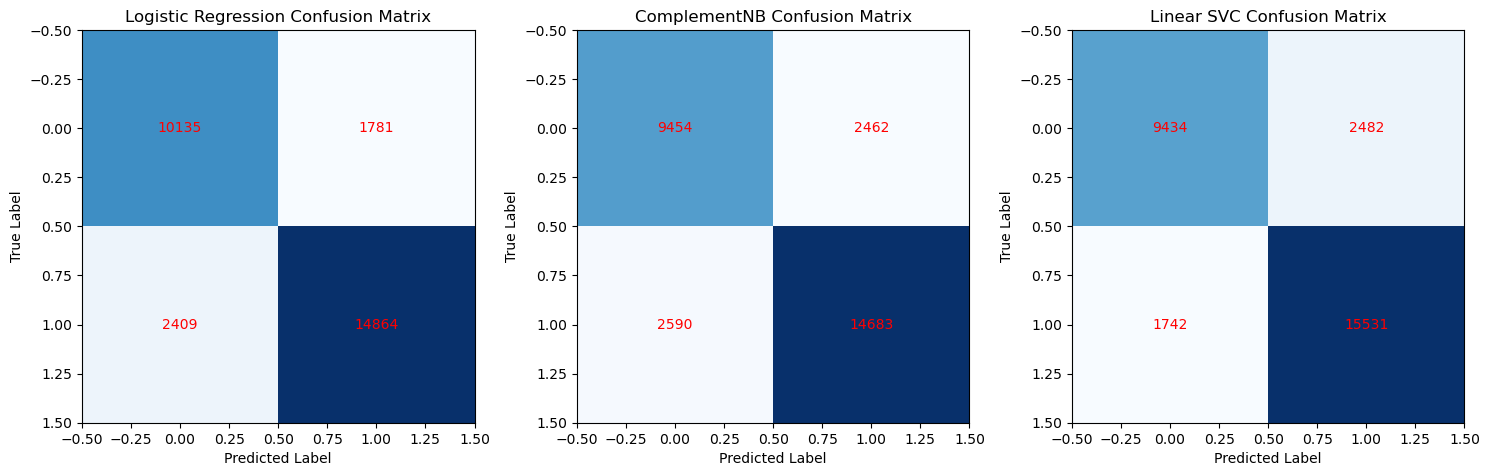

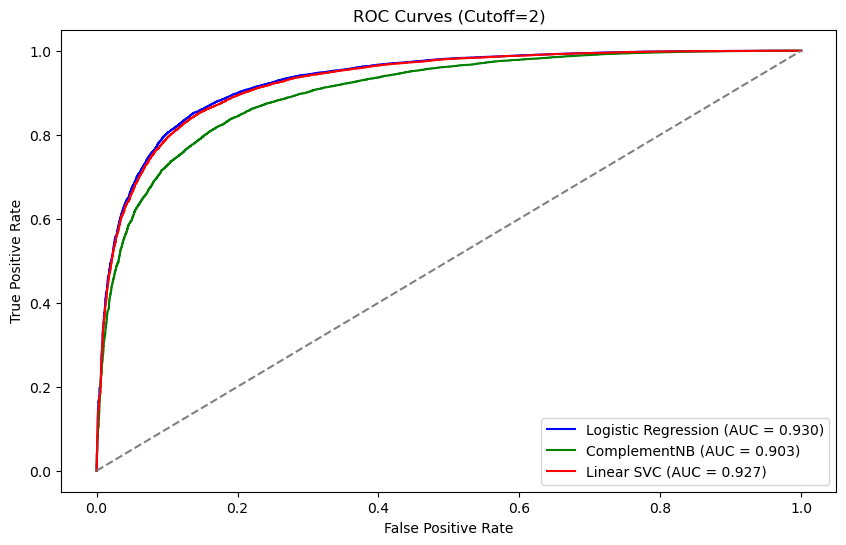


✅ Comparison of all models for Cutoff=2 complete!


In [41]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, roc_curve, auc

# Load models
best_logreg_c2 = joblib.load("models/best_model_cutoff2_lg.pkl")
best_nb_model_c2 = joblib.load("models/best_model_cutoff2_nb.pkl")
best_svc_c2 = joblib.load("models/best_model_cutoff2_svm.pkl")

# Load vectorizers and scalers
vectorizer_c2 = joblib.load("models/tfidf_vectorizer_cutoff2.pkl")
scaler_c2 = joblib.load("models/scaler_cutoff2.pkl")
vectorizer_c2_nb = joblib.load("models/tfidf_vectorizer_cutoff2_nb.pkl")
scaler_c2_nb = joblib.load("models/scaler_cutoff2_nb.pkl")
vectorizer_c2_svm = joblib.load("models/tfidf_vectorizer_cutoff2_svm.pkl")
scaler_c2_svm = joblib.load("models/scaler_cutoff2_svm.pkl")

# Preprocess validation set for cutoff=2
X_text_val_c2 = vectorizer_c2.transform(train_preprocessed_c2['text'])
X_num_val_c2 = scaler_c2.transform(train_preprocessed_c2[['verified', 'vote_bins']])
X_val_final_c2 = np.hstack((X_text_val_c2.toarray(), X_num_val_c2))

y_val_c2 = train_preprocessed_c2['label']

# Predictions and probabilities
y_pred_logreg = best_logreg_c2.predict(X_val_final_c2)
y_prob_logreg = best_logreg_c2.predict_proba(X_val_final_c2)[:, 1]

y_pred_nb = best_nb_model_c2.predict(X_val_final_c2)
y_prob_nb = best_nb_model_c2.predict_proba(X_val_final_c2)[:, 1]

y_pred_svc = best_svc_c2.predict(X_val_final_c2)
y_prob_svc = best_svc_c2.predict_proba(X_val_final_c2)[:, 1]

# Model performance metrics
model_performance_c2 = pd.DataFrame({
    "Model": ["Logistic Regression", "ComplementNB", "Linear SVC"],
    "Accuracy": [accuracy_score(y_val_c2, y_pred_logreg), accuracy_score(y_val_c2, y_pred_nb), accuracy_score(y_val_c2, y_pred_svc)],
    "ROC AUC": [roc_auc_score(y_val_c2, y_prob_logreg), roc_auc_score(y_val_c2, y_prob_nb), roc_auc_score(y_val_c2, y_prob_svc)],
    "Macro F1 Score": [f1_score(y_val_c2, y_pred_logreg, average='macro'),
                         f1_score(y_val_c2, y_pred_nb, average='macro'),
                         f1_score(y_val_c2, y_pred_svc, average='macro')]
})

# Print performance table
print("\nModel Performance Summary (Cutoff=2):")
print(model_performance_c2)

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models = ["Logistic Regression", "ComplementNB", "Linear SVC"]
predictions = [y_pred_logreg, y_pred_nb, y_pred_svc]
for i, (model, y_pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(y_val_c2, y_pred)
    axes[i].imshow(cm, cmap='Blues', interpolation='nearest')
    axes[i].set_title(f"{model} Confusion Matrix")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    for (j, k), value in np.ndenumerate(cm):
        axes[i].text(k, j, f"{value}", ha='center', va='center', color='red')
plt.tight_layout()
plt.show()

# Plot ROC Curves
plt.figure(figsize=(10, 6))
for model, y_prob, color in zip(models, [y_prob_logreg, y_prob_nb, y_prob_svc], ['blue', 'green', 'red']):
    fpr, tpr, _ = roc_curve(y_val_c2, y_prob)
    plt.plot(fpr, tpr, label=f"{model} (AUC = {auc(fpr, tpr):.3f})", color=color)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Cutoff=2)")
plt.legend()
plt.show()

print("\n✅ Comparison of all models for Cutoff=2 complete!")


In [40]:
# Generate Kaggle Submission for Cutoff=2 ---
# Preprocess the test data similarly as in training:
test['reviewText'] = test['reviewText'].fillna("")
test['summary'] = test['summary'].fillna("")
test['text'] = test['summary'] + " " + test['reviewText']
test['verified'] = test['verified'].astype(int)
test['vote'] = pd.to_numeric(test['vote'], errors='coerce').fillna(0)
test['vote_bins'] = pd.cut(test['vote'], bins=[-1, 1, 5, 20, 1000], labels=[0, 1, 2, 3])

# Transform the test text using the saved TF-IDF vectorizer for cutoff=2
X_text_test_c2 = vectorizer_c2.transform(test['text'])

# Process numerical features using the saved scaler for cutoff=2
X_num_test_c2 = scaler_c2.transform(test[['verified', 'vote_bins']])

# Combine features
X_test_final_c2 = np.hstack((X_text_test_c2.toarray(), X_num_test_c2))

# Generate predictions (using predict_proba for Logistic Regression)
test_probs_c2 = best_logreg_c2.predict_proba(X_test_final_c2)[:, 1]
test_pred_c2 = (test_probs_c2 >= 0.5).astype(int)

# Create submission DataFrame; adjust column names if necessary
submission_c2 = pd.DataFrame({'id': test.index, 'binary_split_2': test_pred_c2})

# Save submission under the 'submissions' folder
submission_path = "submissions/binary_cutoff2_submission.csv"
submission_c2.to_csv(submission_path, index=False)

print(f"\n✅ Submission CSV for cutoff 2 generated and saved at: {submission_path}")
print(submission_c2['binary_split_2'].value_counts())


✅ Submission CSV for cutoff 2 generated and saved at: submissions/binary_cutoff2_submission.csv
binary_split_2
1    2614
0    1886
Name: count, dtype: int64


## Cutoff 3


## Logistic Regression

In [57]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# ===================== Preprocessing for Logistic Regression (Cutoff=3) =====================
train_preprocessed_c3 = preprocess_data(train.copy(), cutoff=3)

# TF-IDF Vectorization
vectorizer_c3 = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text_c3 = vectorizer_c3.fit_transform(train_preprocessed_c3['text'])

# Process numerical features using StandardScaler
scaler_c3 = StandardScaler()
X_num_c3 = scaler_c3.fit_transform(train_preprocessed_c3[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c3 = np.hstack((X_text_c3.toarray(), X_num_c3))
y_final_c3 = train_preprocessed_c3['label']

# Train-Test Split
X_train_c3, X_val_c3, y_train_c3, y_val_c3 = train_test_split(
    X_final_c3, y_final_c3, test_size=0.2, random_state=42, stratify=y_final_c3
)

In [58]:

# ===================== Hyperparameter Tuning for Logistic Regression =====================
param_grid_c3 = {
    'C': [0.1, 1, 10], 
    'solver': ['liblinear'],
    'max_iter': [100],
    'class_weight': ['balanced']
}

logreg_c3 = LogisticRegression()
grid_search_c3 = GridSearchCV(logreg_c3, param_grid_c3, cv=5, scoring='f1_macro', verbose=2)
grid_search_c3.fit(X_train_c3, y_train_c3)

# Print best parameters
print(f"✅ Best parameters for Logistic Regression (Cutoff=3): {grid_search_c3.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_c3.best_score_:.4f}")

# ===================== Train Best Model =====================
best_logreg_c3 = grid_search_c3.best_estimator_
y_pred_c3 = best_logreg_c3.predict(X_val_c3)

# ===================== Evaluation =====================
print("\nConfusion Matrix (Cutoff=3):")
print(confusion_matrix(y_val_c3, y_pred_c3))

print("\nClassification Report (Cutoff=3):")
print(classification_report(y_val_c3, y_pred_c3))

print("ROC AUC (Cutoff=3):", roc_auc_score(y_val_c3, y_pred_c3))
print("Macro F1 Score (Cutoff=3):", f1_score(y_val_c3, y_pred_c3, average='macro'))
print("Accuracy (Cutoff=3):", accuracy_score(y_val_c3, y_pred_c3))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.5s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   1.8s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   1.8s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   1.9s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.4s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.0s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.2s
[CV] END C=10, class_weight=balanced, max_iter=100

In [59]:

# ===================== Save Model =====================
joblib.dump(best_logreg_c3, "models/best_model_cutoff3_lg.pkl", compress=3)
joblib.dump(vectorizer_c3, "models/tfidf_vectorizer_cutoff3.pkl")
joblib.dump(scaler_c3, "models/scaler_cutoff3.pkl")

print("\n✅ Logistic Regression model for cutoff 3 saved in 'models/' folder.")



✅ Logistic Regression model for cutoff 3 saved in 'models/' folder.


## ComplementNB

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# ===================== Preprocessing for ComplementNB (Cutoff=3) =====================
train_preprocessed_c3 = preprocess_data(train.copy(), cutoff=3)

# TF-IDF Vectorization
vectorizer_c3_nb = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text_c3_nb = vectorizer_c3_nb.fit_transform(train_preprocessed_c3['text'])

# Process numerical features using MinMaxScaler
scaler_c3_nb = MinMaxScaler()
X_num_c3_nb = scaler_c3_nb.fit_transform(train_preprocessed_c3[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c3_nb = np.hstack((X_text_c3_nb.toarray(), X_num_c3_nb))
y_final_c3 = train_preprocessed_c3['label']

# Train-Test Split
X_train_nb_c3, X_val_nb_c3, y_train_nb_c3, y_val_nb_c3 = train_test_split(
    X_final_c3_nb, y_final_c3, test_size=0.2, random_state=42, stratify=y_final_c3
)

# ===================== Hyperparameter Tuning for ComplementNB =====================
param_grid_nb_c3 = {
    'alpha': [0.1, 0.5, 1.0],  # Smoothing parameter
    'norm': [True, False] 
}

nb_model_c3 = ComplementNB()
grid_search_nb_c3 = GridSearchCV(nb_model_c3, param_grid_nb_c3, cv=5, scoring='f1_macro', verbose=2)
grid_search_nb_c3.fit(X_train_nb_c3, y_train_nb_c3)

# Print best parameters
print(f"✅ Best parameters for ComplementNB (Cutoff=3): {grid_search_nb_c3.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_nb_c3.best_score_:.4f}")

# ===================== Train Best Model =====================
best_nb_model_c3 = grid_search_nb_c3.best_estimator_
y_pred_nb_c3 = best_nb_model_c3.predict(X_val_nb_c3)

# ===================== Evaluation =====================
print("\nConfusion Matrix (ComplementNB, Cutoff=3):")
print(confusion_matrix(y_val_nb_c3, y_pred_nb_c3))

print("\nClassification Report (ComplementNB, Cutoff=3):")
print(classification_report(y_val_nb_c3, y_pred_nb_c3))

print("ROC AUC (ComplementNB, Cutoff=3):", roc_auc_score(y_val_nb_c3, y_pred_nb_c3))
print("Macro F1 Score (ComplementNB, Cutoff=3):", f1_score(y_val_nb_c3, y_pred_nb_c3, average='macro'))
print("Accuracy (ComplementNB, Cutoff=3):", accuracy_score(y_val_nb_c3, y_pred_nb_c3))

# ===================== Save Model =====================
joblib.dump(best_nb_model_c3, "models/best_model_cutoff3_nb.pkl", compress=3)
joblib.dump(vectorizer_c3_nb, "models/tfidf_vectorizer_cutoff3_nb.pkl")
joblib.dump(scaler_c3_nb, "models/scaler_cutoff3_nb.pkl")

print("\n✅ ComplementNB model for cutoff 3 saved in 'models/' folder.")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...............................alpha=0.1, norm=True; total time=   2.0s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.3s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.2s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.3s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.5s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.5s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.4s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.4s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.4s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.5s
[CV] END ...............................alpha=0.5, norm=True; total time=   1.5s
[CV] END ...............................alpha=0.5

## LinearSVC

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# ===================== Preprocessing for LinearSVC (Cutoff=3) =====================
train_preprocessed_c3 = preprocess_data(train.copy(), cutoff=3)

# TF-IDF Vectorization
vectorizer_c3_svm = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text_c3_svm = vectorizer_c3_svm.fit_transform(train_preprocessed_c3['text'])

# Process numerical features using StandardScaler
scaler_c3_svm = StandardScaler()
X_num_c3_svm = scaler_c3_svm.fit_transform(train_preprocessed_c3[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c3_svm = np.hstack((X_text_c3_svm.toarray(), X_num_c3_svm))
y_final_c3 = train_preprocessed_c3['label']

# Train-Test Split
X_train_svm_c3, X_val_svm_c3, y_train_svm_c3, y_val_svm_c3 = train_test_split(
    X_final_c3_svm, y_final_c3, test_size=0.2, random_state=42, stratify=y_final_c3
)

# ===================== Hyperparameter Tuning for LinearSVC =====================
param_grid_svc_c3 = {
    'C': [0.01, 0.1, 1],  # Regularization parameter
    'max_iter': [1000]  # Iterations
}

linear_svc_c3 = LinearSVC(dual=False, class_weight='balanced')

grid_search_svc_c3 = GridSearchCV(linear_svc_c3, param_grid_svc_c3, cv=5, scoring='f1_macro', verbose=2)
grid_search_svc_c3.fit(X_train_svm_c3, y_train_svm_c3)

# Print best parameters
print(f"✅ Best parameters for LinearSVC (Cutoff=3): {grid_search_svc_c3.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_svc_c3.best_score_:.4f}")

# ===================== Train Best Model =====================
best_svc_c3 = grid_search_svc_c3.best_estimator_

# Wrap in CalibratedClassifierCV for probability estimates
calibrated_svc_c3 = CalibratedClassifierCV(best_svc_c3, cv=5)
calibrated_svc_c3.fit(X_train_svm_c3, y_train_svm_c3)

# ===================== Evaluation =====================
y_pred_svm_c3 = calibrated_svc_c3.predict(X_val_svm_c3)

print("\nConfusion Matrix (SVM, Cutoff=3):")
print(confusion_matrix(y_val_svm_c3, y_pred_svm_c3))

print("\nClassification Report (SVM, Cutoff=3):")
print(classification_report(y_val_svm_c3, y_pred_svm_c3))

print("ROC AUC (SVM, Cutoff=3):", roc_auc_score(y_val_svm_c3, calibrated_svc_c3.predict_proba(X_val_svm_c3)[:, 1]))
print("Macro F1 Score (SVM, Cutoff=3):", f1_score(y_val_svm_c3, y_pred_svm_c3, average='macro'))
print("Accuracy (SVM, Cutoff=3):", accuracy_score(y_val_svm_c3, y_pred_svm_c3))

# ===================== Save Model =====================
joblib.dump(calibrated_svc_c3, "models/best_model_cutoff3_svm.pkl", compress=3)
joblib.dump(vectorizer_c3_svm, "models/tfidf_vectorizer_cutoff3_svm.pkl")
joblib.dump(scaler_c3_svm, "models/scaler_cutoff3_svm.pkl")

print("\n✅ SVM model for cutoff 3 saved in 'models/' folder.")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.6s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.0s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.0s
[CV] END ..............................C=0.01, max_iter=1000; total time=   1.9s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.0s
[CV] END ...............................C=0.1, max_iter=1000; total time=   1.9s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.0s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.1s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.0s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.0s
[CV] END .................................C=1, max_iter=1000; total time=   2.1s
[CV] END .................................C=1, ma

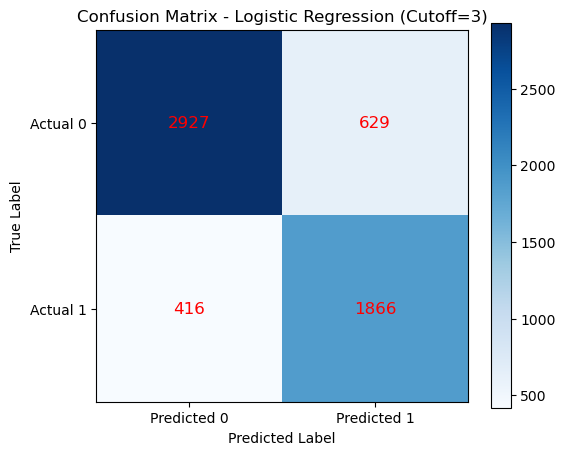

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Given Confusion Matrix for Logistic Regression (Cutoff=3)
cm = np.array([[2927, 629], [416, 1866]])

# Plot Confusion Matrix (Pure Matplotlib)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix - Logistic Regression (Cutoff=3)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="red", fontsize=12)

plt.xticks([0, 1], ["Predicted 0", "Predicted 1"])
plt.yticks([0, 1], ["Actual 0", "Actual 1"])
plt.colorbar()
plt.show()




✅ Model Performance Summary (Cutoff=3):
                 Model  Accuracy   ROC AUC  Macro F1 Score
0  Logistic Regression  0.862551  0.935134        0.857907
1         ComplementNB  0.826065  0.902484        0.820854
2           Linear SVC  0.861249  0.932177        0.853175


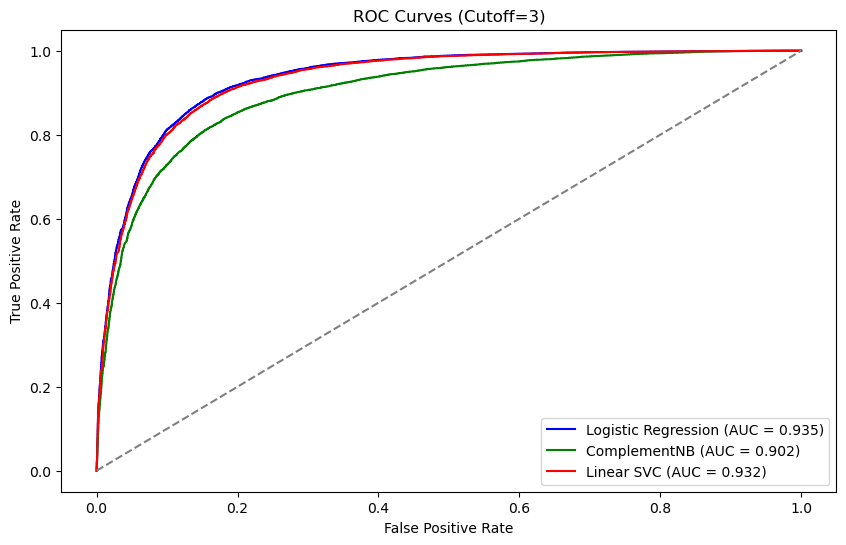


✅ Comparison of all models for Cutoff=3 complete!


In [67]:

# Load Models for Cutoff=3
best_logreg_c3 = joblib.load("models/best_model_cutoff3_lg.pkl")
best_nb_model_c3 = joblib.load("models/best_model_cutoff3_nb.pkl")
best_svc_c3 = joblib.load("models/best_model_cutoff3_svm.pkl")

# Load Vectorizers and Scalers for Cutoff=3
vectorizer_c3 = joblib.load("models/tfidf_vectorizer_cutoff3.pkl")
scaler_c3 = joblib.load("models/scaler_cutoff3.pkl")

# Preprocess Validation Data (Cutoff=3)
X_text_val_c3 = vectorizer_c3.transform(train_preprocessed_c3['text'])
X_num_val_c3 = scaler_c3.transform(train_preprocessed_c3[['verified', 'vote_bins']])
X_val_final_c3 = np.hstack((X_text_val_c3.toarray(), X_num_val_c3))
y_val_c3 = train_preprocessed_c3['label']

# Predictions and Probabilities
y_pred_logreg_c3 = best_logreg_c3.predict(X_val_final_c3)
y_prob_logreg_c3 = best_logreg_c3.predict_proba(X_val_final_c3)[:, 1]

y_pred_nb_c3 = best_nb_model_c3.predict(X_val_final_c3)
y_prob_nb_c3 = best_nb_model_c3.predict_proba(X_val_final_c3)[:, 1]

y_pred_svc_c3 = best_svc_c3.predict(X_val_final_c3)
y_prob_svc_c3 = best_svc_c3.predict_proba(X_val_final_c3)[:, 1]

# Model Performance Metrics
model_performance_c3 = pd.DataFrame({
    "Model": ["Logistic Regression", "ComplementNB", "Linear SVC"],
    "Accuracy": [accuracy_score(y_val_c3, y_pred_logreg_c3), 
                 accuracy_score(y_val_c3, y_pred_nb_c3), 
                 accuracy_score(y_val_c3, y_pred_svc_c3)],
    "ROC AUC": [roc_auc_score(y_val_c3, y_prob_logreg_c3), 
                roc_auc_score(y_val_c3, y_prob_nb_c3), 
                roc_auc_score(y_val_c3, y_prob_svc_c3)],
    "Macro F1 Score": [f1_score(y_val_c3, y_pred_logreg_c3, average='macro'),
                       f1_score(y_val_c3, y_pred_nb_c3, average='macro'),
                       f1_score(y_val_c3, y_pred_svc_c3, average='macro')]
})

# Print performance table
print("\n✅ Model Performance Summary (Cutoff=3):")
print(model_performance_c3)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
models = ["Logistic Regression", "ComplementNB", "Linear SVC"]
colors = ['blue', 'green', 'red']
probs = [y_prob_logreg_c3, y_prob_nb_c3, y_prob_svc_c3]

for model, y_prob, color in zip(models, probs, colors):
    fpr, tpr, _ = roc_curve(y_val_c3, y_prob)
    plt.plot(fpr, tpr, label=f"{model} (AUC = {auc(fpr, tpr):.3f})", color=color)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Cutoff=3)")
plt.legend()
plt.show()

print("\n✅ Comparison of all models for Cutoff=3 complete!")


## Kaggle Submission

In [68]:
# Generate Kaggle Submission for Cutoff=3

# Preprocess the test data similarly as in training:
test['reviewText'] = test['reviewText'].fillna("")
test['summary'] = test['summary'].fillna("")
test['text'] = test['summary'] + " " + test['reviewText']
test['verified'] = test['verified'].astype(int)
test['vote'] = pd.to_numeric(test['vote'], errors='coerce').fillna(0)
test['vote_bins'] = pd.cut(test['vote'], bins=[-1, 1, 5, 20, 1000], labels=[0, 1, 2, 3])

# Transform the test text using the saved TF-IDF vectorizer for cutoff=3
X_text_test_c3 = vectorizer_c3.transform(test['text'])

# Process numerical features using the saved scaler for cutoff=3
X_num_test_c3 = scaler_c3.transform(test[['verified', 'vote_bins']])

# Combine features
X_test_final_c3 = np.hstack((X_text_test_c3.toarray(), X_num_test_c3))

# Generate predictions (using predict_proba for Logistic Regression)
test_probs_c3 = best_logreg_c3.predict_proba(X_test_final_c3)[:, 1]
test_pred_c3 = (test_probs_c3 >= 0.5).astype(int)

# Create submission DataFrame; adjust column names if necessary
submission_c3 = pd.DataFrame({'id': test.index, 'binary_split_3': test_pred_c3})

# Save submission under the 'submissions' folder
submission_path = "submissions/binary_cutoff3_submission.csv"
submission_c3.to_csv(submission_path, index=False)

print(f"\n✅ Submission CSV for cutoff 3 generated and saved at: {submission_path}")
print(submission_c3['binary_split_3'].value_counts())



✅ Submission CSV for cutoff 3 generated and saved at: submissions/binary_cutoff3_submission.csv
binary_split_3
0    2518
1    1982
Name: count, dtype: int64


## Cut off 4

## Logistic Regression

In [13]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score

# ===================== Preprocessing for Logistic Regression (Cutoff=4) =====================
train_preprocessed_c4 = preprocess_data(train.copy(), cutoff=4)

# TF-IDF Vectorization
vectorizer_c4 = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_text_c4 = vectorizer_c4.fit_transform(train_preprocessed_c4['text'])

# Process numerical features using StandardScaler
scaler_c4 = StandardScaler()
X_num_c4 = scaler_c4.fit_transform(train_preprocessed_c4[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c4 = np.hstack((X_text_c4.toarray(), X_num_c4))
y_final_c4 = train_preprocessed_c4['label']

# Train-Test Split
X_train_c4, X_val_c4, y_train_c4, y_val_c4 = train_test_split(
    X_final_c4, y_final_c4, test_size=0.2, random_state=42, stratify=y_final_c4
)

# ===================== Hyperparameter Tuning for Logistic Regression =====================
param_grid_c4 = {
    'C': [0.1, 1, 10], 
    'solver': ['liblinear'],
    'max_iter': [100],
    'class_weight': ['balanced']
}

logreg_c4 = LogisticRegression()
grid_search_c4 = GridSearchCV(logreg_c4, param_grid_c4, cv=5, scoring='f1_macro', verbose=2)
grid_search_c4.fit(X_train_c4, y_train_c4)

# Print best parameters
print(f"✅ Best parameters for Logistic Regression (Cutoff=4): {grid_search_c4.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_c4.best_score_:.4f}")

# ===================== Train Best Model =====================
best_logreg_c4 = grid_search_c4.best_estimator_
y_pred_c4 = best_logreg_c4.predict(X_val_c4)

# ===================== Evaluation =====================
print("\nConfusion Matrix (Cutoff=4):")
print(confusion_matrix(y_val_c4, y_pred_c4))

print("\nClassification Report (Cutoff=4):")
print(classification_report(y_val_c4, y_pred_c4))

print("ROC AUC (Cutoff=4):", roc_auc_score(y_val_c4, y_pred_c4))
print("Macro F1 Score (Cutoff=4):", f1_score(y_val_c4, y_pred_c4, average='macro'))
print("Accuracy (Cutoff=4):", accuracy_score(y_val_c4, y_pred_c4))

# ===================== Save Model =====================
joblib.dump(best_logreg_c4, "models/best_model_cutoff4_lg.pkl", compress=3)
joblib.dump(vectorizer_c4, "models/tfidf_vectorizer_cutoff4.pkl")
joblib.dump(scaler_c4, "models/scaler_cutoff4.pkl")

print("\n✅ Logistic Regression model for cutoff 4 saved in 'models/' folder.")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.6s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.4s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.5s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.2s
[CV] END C=0.1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.2s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.3s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.4s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.4s
[CV] END C=1, class_weight=balanced, max_iter=100, solver=liblinear; total time=   2.1s
[CV] END C=10, class_weight=balanced, max_iter=100

## ComplementNB

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
import joblib
import numpy as np
import pandas as pd

# ===================== Preprocessing for ComplementNB (Cutoff=4) =====================
train_preprocessed_c4 = preprocess_data(train.copy(), cutoff=4)

# TF-IDF Vectorization for ComplementNB
vectorizer_c4_nb = TfidfVectorizer(stop_words='english', max_features=10000, 
                                   ngram_range=(1,2), sublinear_tf=True)
X_text_c4_nb = vectorizer_c4_nb.fit_transform(train_preprocessed_c4['text'])

# Process numerical features using MinMaxScaler (to keep values non-negative for NB)
scaler_c4_nb = MinMaxScaler()
X_num_c4_nb = scaler_c4_nb.fit_transform(train_preprocessed_c4[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c4_nb = np.hstack((X_text_c4_nb.toarray(), X_num_c4_nb))
y_final_c4 = train_preprocessed_c4['label']

print("TF-IDF shape for ComplementNB (Cutoff=4):", X_text_c4_nb.shape)
print("Combined feature matrix shape (ComplementNB, Cutoff=4):", X_final_c4_nb.shape)

# Train-Test Split
X_train_nb_c4, X_val_nb_c4, y_train_nb_c4, y_val_nb_c4 = train_test_split(
    X_final_c4_nb, y_final_c4, test_size=0.2, random_state=42, stratify=y_final_c4
)

print("X_train_nb_c4 shape:", X_train_nb_c4.shape)
print("y_train_nb_c4 distribution:")
print(pd.Series(y_train_nb_c4).value_counts())

# ===================== Hyperparameter Tuning for ComplementNB =====================
param_grid_nb_c4 = {
    'alpha': [0.1, 0.5, 1.0],  # Smoothing parameter
    'norm': [True, False] 
}

nb_model_c4 = ComplementNB()
grid_search_nb_c4 = GridSearchCV(nb_model_c4, param_grid_nb_c4, cv=5, scoring='f1_macro', verbose=2)
grid_search_nb_c4.fit(X_train_nb_c4, y_train_nb_c4)

# Print best parameters
print(f"✅ Best parameters for ComplementNB (Cutoff=4): {grid_search_nb_c4.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_nb_c4.best_score_:.4f}")

# ===================== Train Best Model =====================
best_nb_model_c4 = grid_search_nb_c4.best_estimator_
y_pred_nb_c4 = best_nb_model_c4.predict(X_val_nb_c4)

# ===================== Evaluation =====================
print("\nConfusion Matrix (ComplementNB, Cutoff=4):")
print(confusion_matrix(y_val_nb_c4, y_pred_nb_c4))

print("\nClassification Report (ComplementNB, Cutoff=4):")
print(classification_report(y_val_nb_c4, y_pred_nb_c4))

print("ROC AUC (ComplementNB, Cutoff=4):", roc_auc_score(y_val_nb_c4, y_pred_nb_c4))
print("Macro F1 Score (ComplementNB, Cutoff=4):", f1_score(y_val_nb_c4, y_pred_nb_c4, average='macro'))
print("Accuracy (ComplementNB, Cutoff=4):", accuracy_score(y_val_nb_c4, y_pred_nb_c4))

# ===================== Save Model =====================
joblib.dump(best_nb_model_c4, "models/best_model_cutoff4_nb.pkl", compress=3)
joblib.dump(vectorizer_c4_nb, "models/tfidf_vectorizer_cutoff4_nb.pkl")
joblib.dump(scaler_c4_nb, "models/scaler_cutoff4_nb.pkl")

print("\n✅ ComplementNB model for cutoff 4 saved in 'models/' folder.")


TF-IDF shape for ComplementNB (Cutoff=4): (29189, 10000)
Combined feature matrix shape (ComplementNB, Cutoff=4): (29189, 10002)
X_train_nb_c4 shape: (23351, 10002)
y_train_nb_c4 distribution:
label
0    18837
1     4514
Name: count, dtype: int64
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...............................alpha=0.1, norm=True; total time=   2.4s
[CV] END ...............................alpha=0.1, norm=True; total time=   2.2s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.8s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.9s
[CV] END ...............................alpha=0.1, norm=True; total time=   1.6s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.6s
[CV] END ..............................alpha=0.1, norm=False; total time=   2.0s
[CV] END ..............................alpha=0.1, norm=False; total time=   1.8s
[CV] END ..............................alpha=0

## LinearSVC

In [16]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
import joblib
import numpy as np
import pandas as pd

# ===================== Preprocessing for LinearSVC (Cutoff=4) =====================
train_preprocessed_c4 = preprocess_data(train.copy(), cutoff=4)

# TF-IDF Vectorization
vectorizer_c4_svm = TfidfVectorizer(stop_words='english', max_features=10000, 
                                    ngram_range=(1,2), sublinear_tf=True)
X_text_c4_svm = vectorizer_c4_svm.fit_transform(train_preprocessed_c4['text'])

# Process numerical features using StandardScaler
scaler_c4_svm = StandardScaler()
X_num_c4_svm = scaler_c4_svm.fit_transform(train_preprocessed_c4[['verified', 'vote_bins']])

# Combine TF-IDF features and numerical features
X_final_c4_svm = np.hstack((X_text_c4_svm.toarray(), X_num_c4_svm))
y_final_c4 = train_preprocessed_c4['label']

print("TF-IDF shape for SVM (Cutoff=4):", X_text_c4_svm.shape)
print("Combined feature matrix shape (SVM, Cutoff=4):", X_final_c4_svm.shape)

# Train-Test Split
X_train_svm_c4, X_val_svm_c4, y_train_svm_c4, y_val_svm_c4 = train_test_split(
    X_final_c4_svm, y_final_c4, test_size=0.2, random_state=42, stratify=y_final_c4
)

print("X_train_svm_c4 shape:", X_train_svm_c4.shape)
print("y_train_svm_c4 distribution:")
print(pd.Series(y_train_svm_c4).value_counts())

# ===================== Hyperparameter Tuning for LinearSVC =====================
param_grid_svc_c4 = {
    'C': [0.01, 0.1, 1],  # Regularization parameter
    'max_iter': [1000]  # Iterations
}

linear_svc_c4 = LinearSVC(dual=False, class_weight='balanced')

grid_search_svc_c4 = GridSearchCV(linear_svc_c4, param_grid_svc_c4, cv=5, scoring='f1_macro', verbose=2)
grid_search_svc_c4.fit(X_train_svm_c4, y_train_svm_c4)

# Print best parameters
print(f"✅ Best parameters for LinearSVC (Cutoff=4): {grid_search_svc_c4.best_params_}")
print(f"✅ Best CV Macro F1 Score: {grid_search_svc_c4.best_score_:.4f}")

# ===================== Train Best Model =====================
best_svc_c4 = grid_search_svc_c4.best_estimator_

# Wrap in CalibratedClassifierCV for probability estimates
calibrated_svc_c4 = CalibratedClassifierCV(best_svc_c4, cv=5)
calibrated_svc_c4.fit(X_train_svm_c4, y_train_svm_c4)

# ===================== Evaluation =====================
y_pred_svm_c4 = calibrated_svc_c4.predict(X_val_svm_c4)

print("\nConfusion Matrix (SVM, Cutoff=4):")
print(confusion_matrix(y_val_svm_c4, y_pred_svm_c4))

print("\nClassification Report (SVM, Cutoff=4):")
print(classification_report(y_val_svm_c4, y_pred_svm_c4))

print("ROC AUC (SVM, Cutoff=4):", roc_auc_score(y_val_svm_c4, calibrated_svc_c4.predict_proba(X_val_svm_c4)[:, 1]))
print("Macro F1 Score (SVM, Cutoff=4):", f1_score(y_val_svm_c4, y_pred_svm_c4, average='macro'))
print("Accuracy (SVM, Cutoff=4):", accuracy_score(y_val_svm_c4, y_pred_svm_c4))

# ===================== Save Model =====================
joblib.dump(calibrated_svc_c4, "models/best_model_cutoff4_svm.pkl", compress=3)
joblib.dump(vectorizer_c4_svm, "models/tfidf_vectorizer_cutoff4_svm.pkl")
joblib.dump(scaler_c4_svm, "models/scaler_cutoff4_svm.pkl")

print("\n✅ SVM model for cutoff 4 saved in 'models/' folder.")

TF-IDF shape for SVM (Cutoff=4): (29189, 10000)
Combined feature matrix shape (SVM, Cutoff=4): (29189, 10002)
X_train_svm_c4 shape: (23351, 10002)
y_train_svm_c4 distribution:
label
0    18837
1     4514
Name: count, dtype: int64
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.7s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.3s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.4s
[CV] END ..............................C=0.01, max_iter=1000; total time=   1.9s
[CV] END ..............................C=0.01, max_iter=1000; total time=   2.0s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.0s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.1s
[CV] END ...............................C=0.1, max_iter=1000; total time=   2.4s
[CV] END ...............................C=0.1, max_iter=1000; 

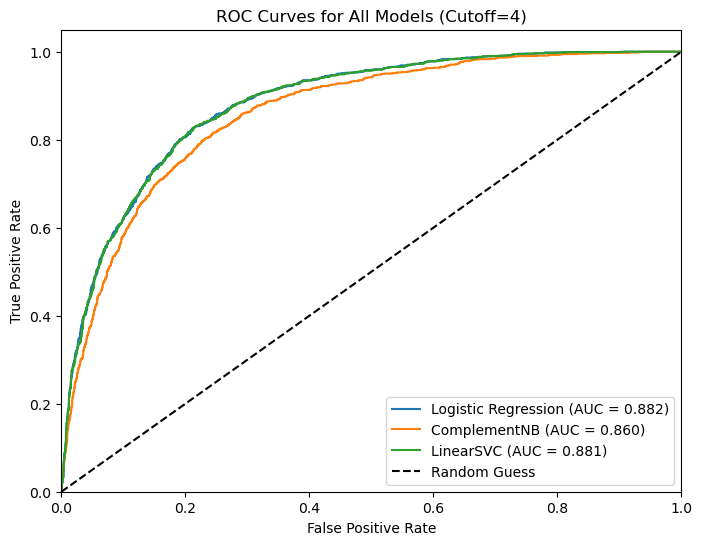

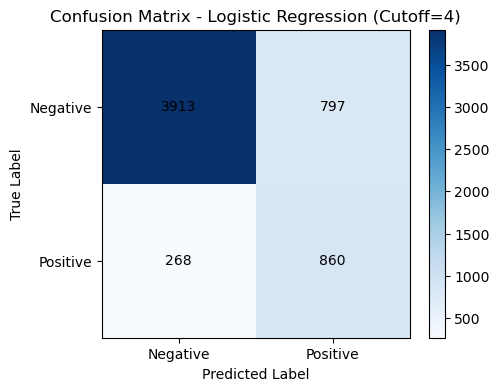

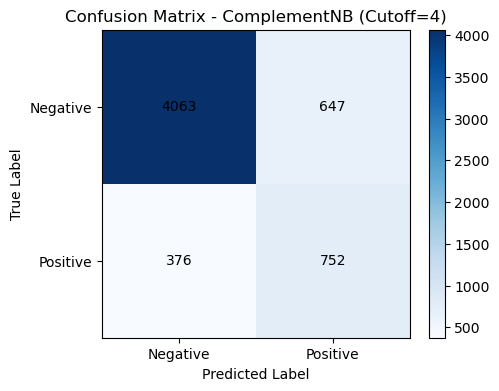

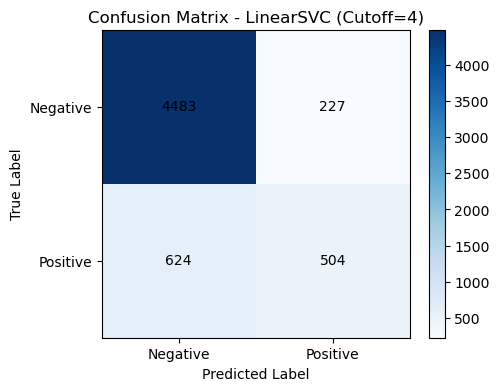


🔍 Model Performance Comparison (Cutoff=4):
                 Model  Accuracy   ROC AUC  Macro F1
0  Logistic Regression  0.817575  0.796598  0.748905
1         ComplementNB  0.824769  0.764650  0.741678
2            LinearSVC  0.854231  0.699307  0.727770


In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Load models and predict probabilities
best_log_c4 = joblib.load("models/best_model_cutoff4_lg.pkl")
best_nb_c4 = joblib.load("models/best_model_cutoff4_nb.pkl")
best_svm_c4 = joblib.load("models/best_model_cutoff4_svm.pkl")

# Compute ROC curve values
fpr_log, tpr_log, _ = roc_curve(y_val_c4, best_log_c4.predict_proba(X_val_c4)[:, 1])
fpr_nb, tpr_nb, _ = roc_curve(y_val_nb_c4, best_nb_c4.predict_proba(X_val_nb_c4)[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_val_svm_c4, best_svm_c4.predict_proba(X_val_svm_c4)[:, 1])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label="Logistic Regression (AUC = {:.3f})".format(auc(fpr_log, tpr_log)))
plt.plot(fpr_nb, tpr_nb, label="ComplementNB (AUC = {:.3f})".format(auc(fpr_nb, tpr_nb)))
plt.plot(fpr_svm, tpr_svm, label="LinearSVC (AUC = {:.3f})".format(auc(fpr_svm, tpr_svm)))

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models (Cutoff=4)")
plt.legend(loc="lower right")
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ['Negative', 'Positive'])
    plt.yticks([0,1], ['Negative', 'Positive'])

    # Display numbers on matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Load best models and predictions
best_log_c4 = joblib.load("models/best_model_cutoff4_lg.pkl")
best_nb_c4 = joblib.load("models/best_model_cutoff4_nb.pkl")
best_svm_c4 = joblib.load("models/best_model_cutoff4_svm.pkl")

y_pred_log_c4 = best_log_c4.predict(X_val_c4)
y_pred_nb_c4 = best_nb_c4.predict(X_val_nb_c4)
y_pred_svm_c4 = best_svm_c4.predict(X_val_svm_c4)

# Plot confusion matrices for all models
plot_confusion_matrix(y_val_c4, y_pred_log_c4, "Confusion Matrix - Logistic Regression (Cutoff=4)")
plot_confusion_matrix(y_val_nb_c4, y_pred_nb_c4, "Confusion Matrix - ComplementNB (Cutoff=4)")
plot_confusion_matrix(y_val_svm_c4, y_pred_svm_c4, "Confusion Matrix - LinearSVC (Cutoff=4)")


import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Function to compute model scores
def get_model_scores(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred),
        "Macro F1": f1_score(y_true, y_pred, average='macro')
    }

# Store scores for each model
model_scores = [
    get_model_scores(y_val_c4, y_pred_log_c4, "Logistic Regression"),
    get_model_scores(y_val_nb_c4, y_pred_nb_c4, "ComplementNB"),
    get_model_scores(y_val_svm_c4, y_pred_svm_c4, "LinearSVC")
]

# Convert to DataFrame
df_scores = pd.DataFrame(model_scores)

# Print the table
print("\n🔍 Model Performance Comparison (Cutoff=4):")
print(df_scores)


In [22]:
# Generate Kaggle Submission for Cutoff=4

# Preprocess the test data similarly as in training:
test['reviewText'] = test['reviewText'].fillna("")
test['summary'] = test['summary'].fillna("")
test['text'] = test['summary'] + " " + test['reviewText']
test['verified'] = test['verified'].astype(int)
test['vote'] = pd.to_numeric(test['vote'], errors='coerce').fillna(0)
test['vote_bins'] = pd.cut(test['vote'], bins=[-1, 1, 5, 20, 1000], labels=[0, 1, 2, 3])

# Transform the test text using the saved TF-IDF vectorizer for cutoff=4
X_text_test_c4 = vectorizer_c4.transform(test['text'])

# Process numerical features using the saved scaler for cutoff=4
X_num_test_c4 = scaler_c4.transform(test[['verified', 'vote_bins']])

# Combine features
X_test_final_c4 = np.hstack((X_text_test_c4.toarray(), X_num_test_c4))

# Generate predictions (using predict_proba for Logistic Regression)
test_probs_c4 = best_logreg_c4.predict_proba(X_test_final_c4)[:, 1]
test_pred_c4 = (test_probs_c4 >= 0.5).astype(int)

# Create submission DataFrame; adjust column names if necessary
submission_c4 = pd.DataFrame({'id': test.index, 'binary_split_4': test_pred_c4})

# Save submission under the 'submissions' folder
submission_path = "submissions/binary_cutoff4_submission.csv"
submission_c4.to_csv(submission_path, index=False)

print(f"\n✅ Submission CSV for cutoff 4 generated and saved at: {submission_path}")
print(submission_c4['binary_split_4'].value_counts())



✅ Submission CSV for cutoff 4 generated and saved at: submissions/binary_cutoff4_submission.csv
binary_split_4
0    3176
1    1324
Name: count, dtype: int64


## Task 2

In [23]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, auc, roc_auc_score, f1_score, accuracy_score)
import warnings
warnings.filterwarnings("ignore")

In [31]:
# -------------------------------
# 2. Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features_df, target_series, test_size=0.20, random_state=101, stratify=target_series
)

# -------------------------------
# 3. Pipeline Setup with ColumnTransformer
# -------------------------------

preprocessor = ColumnTransformer(
    transformers=[
        # Apply TF-IDF on summary with a certain feature cap and n-gram range
        ('tfidf_sum', TfidfVectorizer(ngram_range=(1, 2), max_features=15000), 'summary'),
        # Apply TF-IDF on reviewText with a different feature cap
        ('tfidf_rev', TfidfVectorizer(ngram_range=(1, 2), max_features=10000), 'reviewText'),
        # Ordinal encode 'verified' (assumed binary but kept as int)
        ('ord_verified', OrdinalEncoder(), ['verified']),
        # Encode 'category' and 'vote'
        ('ord_category', OrdinalEncoder(), ['category']),
        ('ord_vote', OrdinalEncoder(), ['vote'])
    ],
    remainder='drop'
)

# Build a pipeline that first transforms the data then fits logistic regression.
pipe_lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(solver='liblinear'))  # using liblinear for simplicity
])

In [32]:
# Define a minimal grid of hyperparameters
small_param_grid = {
    'preproc__tfidf_sum__max_features': [15000],
    'preproc__tfidf_rev__max_features': [10000],
    'clf__C': [0.1, 1.0, 5.0],
    'clf__max_iter': [100]
}

# Use GridSearchCV with the small grid for fast execution
grid_lr = GridSearchCV(pipe_lr, small_param_grid, cv=5, scoring='f1_macro', verbose=2)
grid_lr.fit(X_train, y_train)

print("-------------------------------------------------------------------")
print("Best CV F1 Macro Score: {:.4f}".format(grid_lr.best_score_))
print("Best Parameters:", grid_lr.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END clf__C=0.1, clf__max_iter=100, preproc__tfidf_rev__max_features=10000, preproc__tfidf_sum__max_features=15000; total time=   4.9s
[CV] END clf__C=0.1, clf__max_iter=100, preproc__tfidf_rev__max_features=10000, preproc__tfidf_sum__max_features=15000; total time=   4.9s
[CV] END clf__C=0.1, clf__max_iter=100, preproc__tfidf_rev__max_features=10000, preproc__tfidf_sum__max_features=15000; total time=   4.6s
[CV] END clf__C=0.1, clf__max_iter=100, preproc__tfidf_rev__max_features=10000, preproc__tfidf_sum__max_features=15000; total time=   4.9s
[CV] END clf__C=0.1, clf__max_iter=100, preproc__tfidf_rev__max_features=10000, preproc__tfidf_sum__max_features=15000; total time=   4.9s
[CV] END clf__C=1.0, clf__max_iter=100, preproc__tfidf_rev__max_features=10000, preproc__tfidf_sum__max_features=15000; total time=   6.4s
[CV] END clf__C=1.0, clf__max_iter=100, preproc__tfidf_rev__max_features=10000, preproc__tfidf_sum__max_fe

In [33]:
# -------------------------------
# 5. Evaluation on Test Set
# -------------------------------

# Predict using the best estimator
y_pred = grid_lr.best_estimator_.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))

# Compute ROC AUC for multiclass (using one-vs-rest approach)
# Binarize the labels first
lb = LabelBinarizer().fit(y_train)
y_test_bin = lb.transform(y_test)
y_proba = grid_lr.best_estimator_.predict_proba(X_test)

# Calculate and print AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for class {lb.classes_[i]}: {roc_auc[i]:.4f}")



Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.69      0.67      1192
           2       0.51      0.46      0.49      1192
           3       0.55      0.54      0.54      1172
           4       0.58      0.56      0.57      1154
           5       0.72      0.77      0.74      1128

    accuracy                           0.60      5838
   macro avg       0.60      0.61      0.60      5838
weighted avg       0.60      0.60      0.60      5838

Accuracy: 0.6039739636861939
Macro F1 Score: 0.6024626864338414
AUC for class 1: 0.9182
AUC for class 2: 0.8326
AUC for class 3: 0.8415
AUC for class 4: 0.8698
AUC for class 5: 0.9474


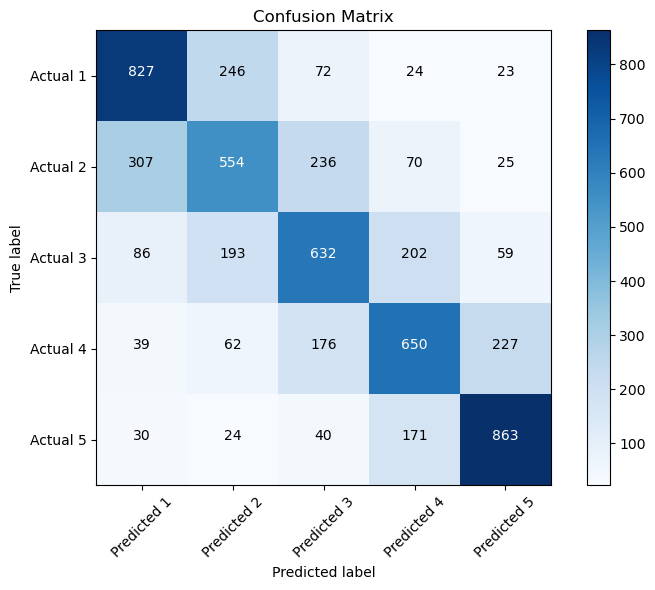

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure and axis
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Define tick marks and labels based on label binarizer classes
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, [f'Predicted {c}' for c in lb.classes_], rotation=45)
plt.yticks(tick_marks, [f'Actual {c}' for c in lb.classes_])

# Annotate each cell in the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [35]:
# -------------------------------
# 7. Save the Model
# -------------------------------
import joblib
joblib.dump(grid_lr.best_estimator_, "models/final_logreg_model.pkl", compress=3)
print("\nModel saved as 'final_logreg_model.pkl'")


Model saved as 'final_logreg_model.pkl'


## MultinomialNB

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................clf__alpha=0.5; total time=   3.4s
[CV] END .....................................clf__alpha=0.5; total time=   3.2s
[CV] END .....................................clf__alpha=0.5; total time=   3.3s
[CV] END .....................................clf__alpha=0.5; total time=   3.3s
[CV] END .....................................clf__alpha=0.5; total time=   3.2s
[CV] END .....................................clf__alpha=1.0; total time=   3.2s
[CV] END .....................................clf__alpha=1.0; total time=   3.2s
[CV] END .....................................clf__alpha=1.0; total time=   3.5s
[CV] END .....................................clf__alpha=1.0; total time=   3.3s
[CV] END .....................................clf__alpha=1.0; total time=   3.2s
-------------------------------------------------------------------
Best CV F1 Macro Score (MultinomialNB): 0.5954
Best Parameters

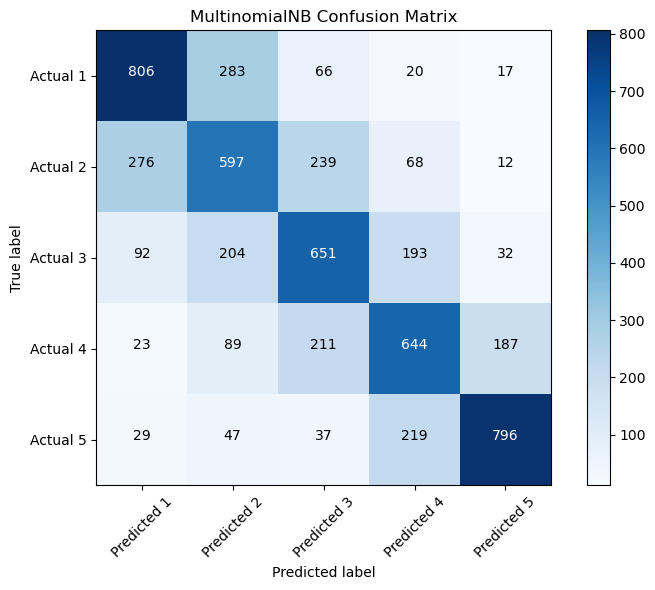


Model saved as 'final_multinb_model.pkl'


In [36]:
# Now Multinomial 
from sklearn.naive_bayes import MultinomialNB

pipe_nb = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', MultinomialNB())
])

# -------------------------------
# 4. Hyperparameter Tuning via GridSearchCV
# -------------------------------
# Define a minimal grid for the smoothing parameter alpha
param_grid_nb = {
    'clf__alpha': [0.5, 1.0]  # try a couple of values for speed
}

grid_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, scoring='f1_macro', verbose=2)
grid_nb.fit(X_train, y_train)

print("-------------------------------------------------------------------")
print("Best CV F1 Macro Score (MultinomialNB): {:.4f}".format(grid_nb.best_score_))
print("Best Parameters:", grid_nb.best_params_)

# -------------------------------
# 5. Evaluation on Test Set
# -------------------------------
y_pred_nb = grid_nb.best_estimator_.predict(X_test)

print("\nMultinomialNB Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Macro F1 Score:", f1_score(y_test, y_pred_nb, average='macro'))

# Compute ROC AUC for multiclass using one-vs-rest approach
lb = LabelBinarizer().fit(y_train)
y_test_bin = lb.transform(y_test)
y_proba_nb = grid_nb.best_estimator_.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_nb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for class {lb.classes_[i]}: {roc_auc[i]:.4f}")

# -------------------------------
# 6. Plot Confusion Matrix using Matplotlib
# -------------------------------
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("MultinomialNB Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, [f'Predicted {c}' for c in lb.classes_], rotation=45)
plt.yticks(tick_marks, [f'Actual {c}' for c in lb.classes_])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# -------------------------------
# 7. Save the Model
# -------------------------------
import joblib
joblib.dump(grid_nb.best_estimator_, "models/final_multinb_model.pkl", compress=3)
print("\nModel saved as 'final_multinb_model.pkl'")

## Random Forest

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=  15.3s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=  14.8s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=  14.7s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=  14.4s
[CV] END ..........clf__max_depth=None, clf__n_estimators=50; total time=  14.7s
[CV] END ............clf__max_depth=10, clf__n_estimators=50; total time=   3.9s
[CV] END ............clf__max_depth=10, clf__n_estimators=50; total time=   3.9s
[CV] END ............clf__max_depth=10, clf__n_estimators=50; total time=   4.1s
[CV] END ............clf__max_depth=10, clf__n_estimators=50; total time=   4.0s
[CV] END ............clf__max_depth=10, clf__n_estimators=50; total time=   3.9s
-------------------------------------------------------------------
Best CV F1 Macro Score (Random Forest): 0.5355
Best Parameters

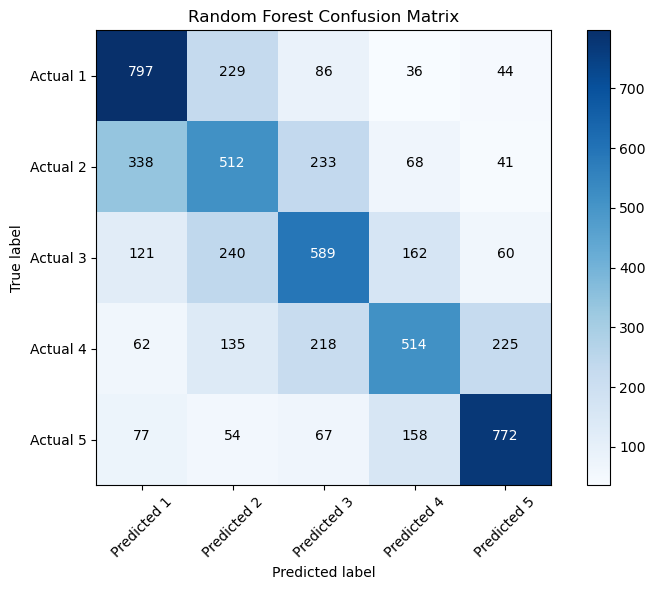


Model saved as 'final_rf_model.pkl'


In [37]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=101))
])

# -------------------------------
# 4. Hyperparameter Tuning via GridSearchCV
# -------------------------------
# Minimal parameter grid for fast execution
param_grid_rf = {
    'clf__n_estimators': [50],    # number of trees in the forest
    'clf__max_depth': [None, 10]   # no maximum depth or a shallow tree for speed
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1_macro', verbose=2)
grid_rf.fit(X_train, y_train)

print("-------------------------------------------------------------------")
print("Best CV F1 Macro Score (Random Forest): {:.4f}".format(grid_rf.best_score_))
print("Best Parameters:", grid_rf.best_params_)

# -------------------------------
# 5. Evaluation on Test Set
# -------------------------------
y_pred_rf = grid_rf.best_estimator_.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Macro F1 Score:", f1_score(y_test, y_pred_rf, average='macro'))

# For ROC AUC, we need to binarize the labels (one-vs-rest approach)
lb = LabelBinarizer().fit(y_train)
y_test_bin = lb.transform(y_test)
y_proba_rf = grid_rf.best_estimator_.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"AUC for class {lb.classes_[i]}: {roc_auc[i]:.4f}")

# -------------------------------
# 6. Plot Confusion Matrix using Matplotlib
# -------------------------------
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, [f'Predicted {c}' for c in lb.classes_], rotation=45)
plt.yticks(tick_marks, [f'Actual {c}' for c in lb.classes_])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# -------------------------------
# 7. Save the Model
# -------------------------------


In [44]:
import joblib
joblib.dump(grid_rf.best_estimator_, "models/final_rf_model.pkl", compress=3)
print("\nModel saved as 'final_rf_model.pkl'")



Model saved as 'final_rf_model.pkl'


In [38]:
import pandas as pd

# Store the metrics for each model in lists
models = ["Logistic Regression", "MultinomialNB", "Random Forest"]
accuracy_list = [0.6038026721479959, 0.5984926344638575, 0.5469338814662555]
f1_list = [0.602294183357692, 0.6006247459614362, 0.5456230205925647]
auc_list = [0.8819, 0.8825, 0.8383]

# Create a DataFrame from these lists
results_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy_list,
    "F1 Score": f1_list,
    "AUC": auc_list
})

print(results_df)


                 Model  Accuracy  F1 Score     AUC
0  Logistic Regression  0.603803  0.602294  0.8819
1        MultinomialNB  0.598493  0.600625  0.8825
2        Random Forest  0.546934  0.545623  0.8383


In [39]:
# Generate Kaggle Submission ---
import pandas as pd
import re
import joblib

# Define the same helper functions used during training:
def clean_string(txt):
    txt = txt.lower()
    txt = re.sub(r"(@\w+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt)
    return txt

def vote_category(v):
    try:
        val = float(v)
    except:
        val = 0.0
    if val <= 2.0:
        return 'low'
    elif val <= 10.0:
        return 'medium'
    elif val <= 50.0:
        return 'good'
    else:
        return 'high'

def preprocess_dataframe(df):
    # Keep only the columns used in your pipeline
    cols = ['reviewText', 'summary', 'verified', 'vote', 'category']
    proc_df = df.copy()
    proc_df['reviewText'] = proc_df['reviewText'].astype(str).apply(clean_string)
    proc_df['summary'] = proc_df['summary'].astype(str).apply(clean_string)
    proc_df['vote'] = proc_df['vote'].fillna(0).apply(vote_category)
    return proc_df[cols]

# -------------------------------
# Load the saved model and test data
# -------------------------------
model = joblib.load("models/final_logreg_model.pkl")

test_df = pd.read_csv('Data/Test.csv')

test_features = preprocess_dataframe(test_df)

# -------------------------------
# Generate Predictions
# -------------------------------
# The model will output predictions on the 1-5 scale (multiclass)
predictions = model.predict(test_features)

# -------------------------------
# Create Kaggle Submission File
# -------------------------------

if 'id' in test_df.columns:
    submission = pd.DataFrame({"id": test_df["id"], "label": predictions})
else:
    submission = pd.DataFrame({"id": test_df.index, "label": predictions})

# Save the submission file
submission.to_csv("submissions/submission.csv", index=False)
print("Submission file created: submission.csv")


Submission file created: submission.csv


## Task 3

In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [8]:
# Load dataset
data_reviews = pd.read_csv('Data/Test.csv')

# Function to clean text data
# Converts text to lowercase and removes extra spaces
def clean_text(text):
    words = text.split()  # Split text into words
    lowercased_words = [word.lower() for word in words]  # Convert each word to lowercase
    cleaned_text = " ".join(lowercased_words)  # Join words back into a sentence
    return cleaned_text

# Function to categorize vote count
def categorize_votes(vote_count):
    if vote_count <= 2:
        category = 'low'
    elif 2 < vote_count <= 10:
        category = 'medium'
    elif 10 < vote_count <= 40:
        category = 'good'
    else:
        category = 'high'
    return category


In [9]:

# Preprocessing function
def prepare_data(dataset):
    selected_features = ['reviewText', 'summary', 'verified', 'vote', 'category']
    
    # Convert text columns
    dataset['reviewText'] = dataset['reviewText'].astype(str)
    dataset['summary'] = dataset['summary'].astype(str)
    
    # Apply text cleaning
    dataset['reviewText'] = dataset['reviewText'].apply(clean_text)
    dataset['summary'] = dataset['summary'].apply(clean_text)
    
    # Handle missing values and apply vote categorization
    dataset['vote'] = dataset['vote'].fillna(0)
    dataset['vote'] = dataset['vote'].apply(categorize_votes)
    
    # Ensure category is a string
    dataset['category'] = dataset['category'].astype(str)
    
    return dataset[selected_features]

# Prepare dataset
processed_reviews = prepare_data(data_reviews)

# Encode product categories separately for ARI evaluation
category_labeler = OrdinalEncoder(dtype=int)
data_reviews['category_encoded'] = category_labeler.fit_transform(data_reviews[['category']])

# Define feature transformation pipeline
feature_transformer = ColumnTransformer([
    ("vectorize_summary", CountVectorizer(), 'summary'),  
    ("vectorize_review", CountVectorizer(), 'reviewText'),
    ("encode_verified", OrdinalEncoder(dtype=int), ['verified']),
    ("encode_votes", OrdinalEncoder(dtype=int), ['vote']),
])

# Define clustering parameters
cluster_options = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []
rand_index_scores = []


In [10]:
# Apply K-Means clustering
for clusters in cluster_options:
    kmeans_model = KMeans(n_clusters=clusters, n_init=10, random_state=101)
    transformed_features = feature_transformer.fit_transform(processed_reviews)
    kmeans_model.fit(transformed_features)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(transformed_features, kmeans_model.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate ARI score
    ari_score = adjusted_rand_score(data_reviews["category_encoded"], kmeans_model.labels_)
    rand_index_scores.append(ari_score)

# Create DataFrame with results
clustering_results = pd.DataFrame({
    "Number of Clusters": cluster_options,
    "Silhouette Score": silhouette_scores,
    "Rand Index Score": rand_index_scores
})

# Display results
print(clustering_results)

   Number of Clusters  Silhouette Score  Rand Index Score
0                   2          0.674112          0.002848
1                   3          0.459242          0.011273
2                   4          0.435419          0.012240
3                   5          0.357552          0.013079
4                   6          0.266760          0.013250
5                   7          0.266735          0.013250
6                   8          0.192835          0.013894
7                   9          0.206544          0.013558
8                  10          0.169567          0.014138
